In [16]:
# ARIMAX vs SARIMAX Model Comparison
# This notebook compares ARIMAX and SARIMAX models on the Air Passengers dataset

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

print("Libraries imported successfully!")


Libraries imported successfully!


In [17]:
# 1. Load and prepare the data
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index(['Month'])

print("=" * 70)
print("DATA OVERVIEW")
print("=" * 70)
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData statistics:")
print(df.describe())
print("=" * 70)


DATA OVERVIEW
Dataset shape: (144, 1)
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00

First few rows:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

Data statistics:
       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000


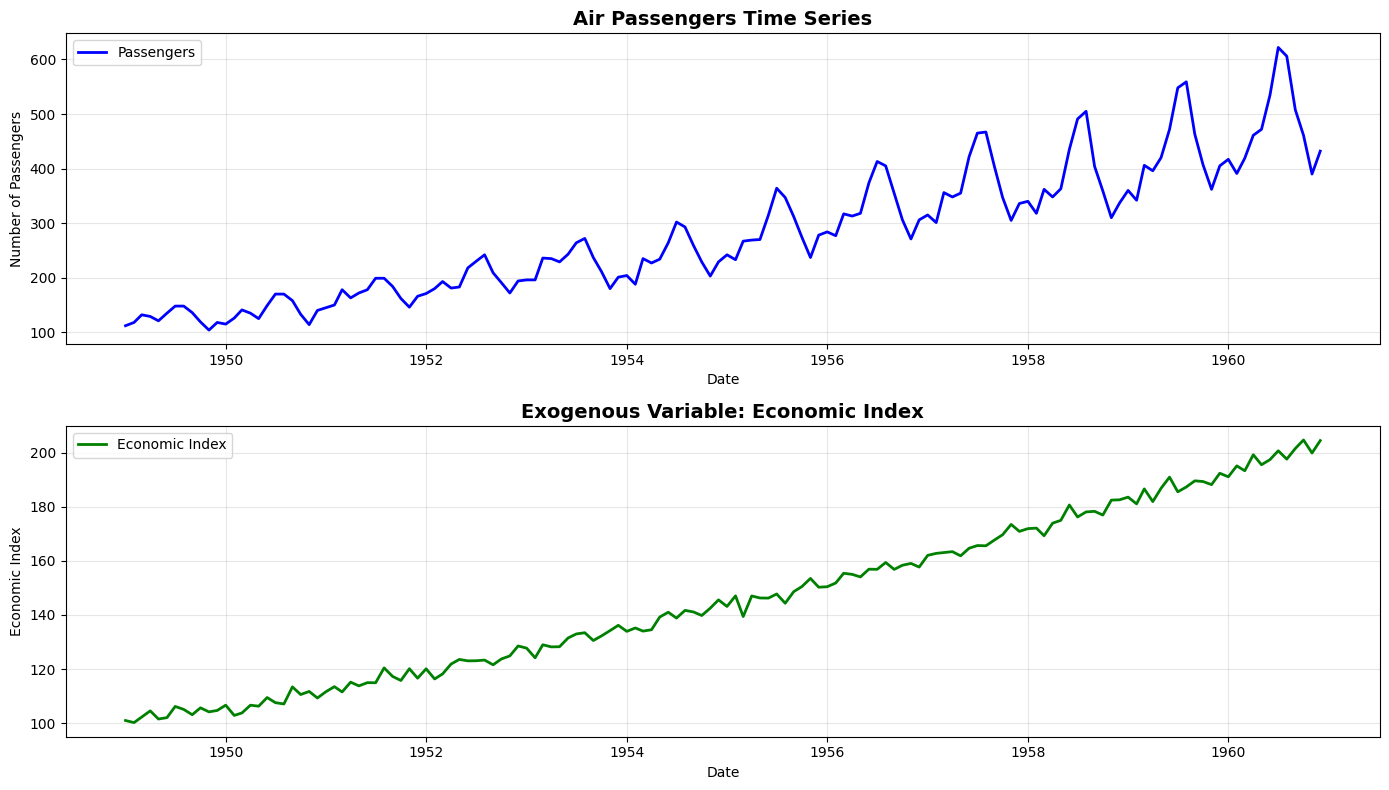


Correlation between Passengers and Economic Index: 0.9268


In [18]:
# 2. Create exogenous variable (Economic Index)
# Simulating economic growth that influences air travel

np.random.seed(42)
base_value = 100
growth_rate = 0.005  # 0.5% monthly growth
n_months = len(df)
time_trend = np.arange(n_months)
economic_index = base_value * (1 + growth_rate) ** time_trend
economic_index += np.random.normal(0, 2, n_months)  # Add noise

df['Economic_Index'] = economic_index

# Plot original data and exogenous variable
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(df.index, df['#Passengers'], label='Passengers', color='blue', linewidth=2)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Passengers')
axes[0].set_title('Air Passengers Time Series', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df.index, df['Economic_Index'], label='Economic Index', color='green', linewidth=2)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Economic Index')
axes[1].set_title('Exogenous Variable: Economic Index', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelation between Passengers and Economic Index: {df['#Passengers'].corr(df['Economic_Index']):.4f}")


In [19]:
# 3. Check stationarity function
def adf_test(series, name=''):
    """Augmented Dickey-Fuller test for stationarity"""
    print(f'--- ADF Test for {name} ---')
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.4f}')
    if result[1] <= 0.05:
        print('Conclusion: Series is Stationary ✓')
        return True
    else:
        print('Conclusion: Series is Non-Stationary ✗')
        return False

# Test original passenger data
print("=" * 70)
print("STATIONARITY TESTS")
print("=" * 70)
print("\n1. ENDOGENOUS VARIABLE (Passengers):")
is_passengers_stationary = adf_test(df['#Passengers'], 'Original #Passengers')

# Test exogenous variable
print("\n2. EXOGENOUS VARIABLE (Economic Index):")
is_exog_stationary = adf_test(df['Economic_Index'], 'Original Economic Index')
print("=" * 70)


STATIONARITY TESTS

1. ENDOGENOUS VARIABLE (Passengers):
--- ADF Test for Original #Passengers ---
ADF Statistic: 0.8154
p-value: 0.9919
Critical Values:
  1%: -3.4817
  5%: -2.8840
  10%: -2.5788
Conclusion: Series is Non-Stationary ✗

2. EXOGENOUS VARIABLE (Economic Index):
--- ADF Test for Original Economic Index ---
ADF Statistic: 4.0353
p-value: 1.0000
Critical Values:
  1%: -3.4805
  5%: -2.8835
  10%: -2.5785
Conclusion: Series is Non-Stationary ✗


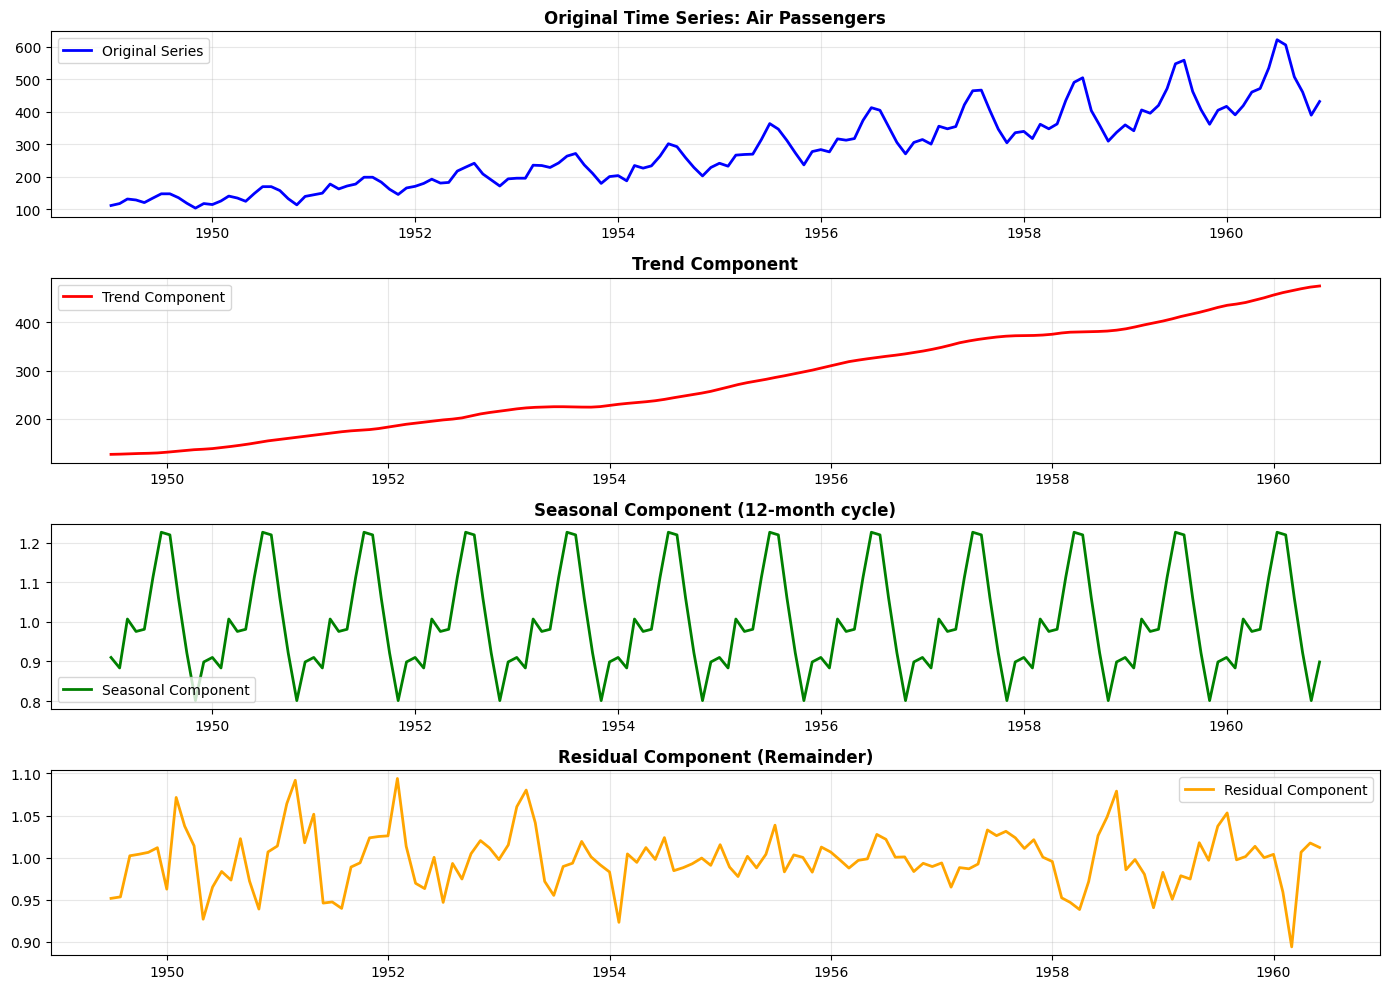


SEASONAL DECOMPOSITION INTERPRETATION

1. TREND COMPONENT:
   • Mean trend value: 278.00
   • Trend shows upward growth
   • Growth from start to end: 274.66%
   • The trend captures the long-term upward pattern in air passenger demand
   • This suggests a growing market for air travel over the 12-year period

2. SEASONAL COMPONENT:
   • Seasonal pattern range: 0.801 to 1.227
   • Peak season: Month 7 (multiplicative factor: 1.227)
   • Lowest season: Month 11 (multiplicative factor: 0.801)
   • The seasonal component shows clear 12-month cyclical patterns
   • Multiplicative model indicates that seasonal variation scales with the trend
   • This suggests peak seasons (e.g., summer/holiday travel) and off-seasons

3. RESIDUAL COMPONENT:
   • Residual mean: 0.9982
   • Residual std: 0.0334
   • Residual range: [0.8941, 1.0940]
   • Residuals show slight negative bias
   • The residuals represent the unexplained variation after removing trend and seasonality
   • These should be random 

In [20]:
# 4. Seasonal Decomposition Analysis
result = seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(df['#Passengers'], label='Original Series', color='blue', linewidth=2)
plt.title('Original Time Series: Air Passengers', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend Component', color='red', linewidth=2)
plt.title('Trend Component', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal Component', color='green', linewidth=2)
plt.title('Seasonal Component (12-month cycle)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual Component', color='orange', linewidth=2)
plt.title('Residual Component (Remainder)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretation of Seasonal Decomposition
print("\n" + "=" * 70)
print("SEASONAL DECOMPOSITION INTERPRETATION")
print("=" * 70)
print("\n1. TREND COMPONENT:")
print(f"   • Mean trend value: {trend.mean():.2f}")
print(f"   • Trend shows {'upward' if trend.iloc[-1] > trend.iloc[0] else 'downward'} growth")
print(f"   • Growth from start to end: {((trend.iloc[-1] / trend.iloc[0] - 1) * 100):.2f}%")
print("   • The trend captures the long-term upward pattern in air passenger demand")
print("   • This suggests a growing market for air travel over the 12-year period")

print("\n2. SEASONAL COMPONENT:")
print(f"   • Seasonal pattern range: {seasonal.min():.3f} to {seasonal.max():.3f}")
print(f"   • Peak season: Month {seasonal.idxmax().month} (multiplicative factor: {seasonal.max():.3f})")
print(f"   • Lowest season: Month {seasonal.idxmin().month} (multiplicative factor: {seasonal.min():.3f})")
print("   • The seasonal component shows clear 12-month cyclical patterns")
print("   • Multiplicative model indicates that seasonal variation scales with the trend")
print("   • This suggests peak seasons (e.g., summer/holiday travel) and off-seasons")

print("\n3. RESIDUAL COMPONENT:")
print(f"   • Residual mean: {residual.mean():.4f}")
print(f"   • Residual std: {residual.std():.4f}")
print(f"   • Residual range: [{residual.min():.4f}, {residual.max():.4f}]")
if abs(residual.mean()) < 0.05:
    print("   • Residuals are centered around 1.0 (good for multiplicative model)")
else:
    print(f"   • Residuals show slight {'positive' if residual.mean() > 1 else 'negative'} bias")
print("   • The residuals represent the unexplained variation after removing trend and seasonality")
print("   • These should be random noise if the decomposition captures all patterns well")

print("\n4. KEY INSIGHTS:")
print("   • The series exhibits STRONG SEASONALITY with a 12-month period")
print("   • The TREND is clearly UPWARD, indicating growth in air travel")
print("   • The MULTIPLICATIVE model is appropriate (seasonal variation increases with trend)")
print("   • This suggests SARIMAX would be better than ARIMAX for this dataset")
print("   • The seasonal patterns need to be explicitly modeled (D=1 for seasonal differencing)")
print("=" * 70)


ACF AND PACF ANALYSIS - ORIGINAL SERIES (BEFORE DIFFERENCING)

These plots show the autocorrelation patterns in the NON-STATIONARY series.
We expect to see:
  • Slow decay in ACF indicating non-stationarity
  • Significant spikes at seasonal lags (12, 24, 36 months)
  • Patterns that will guide our differencing strategy


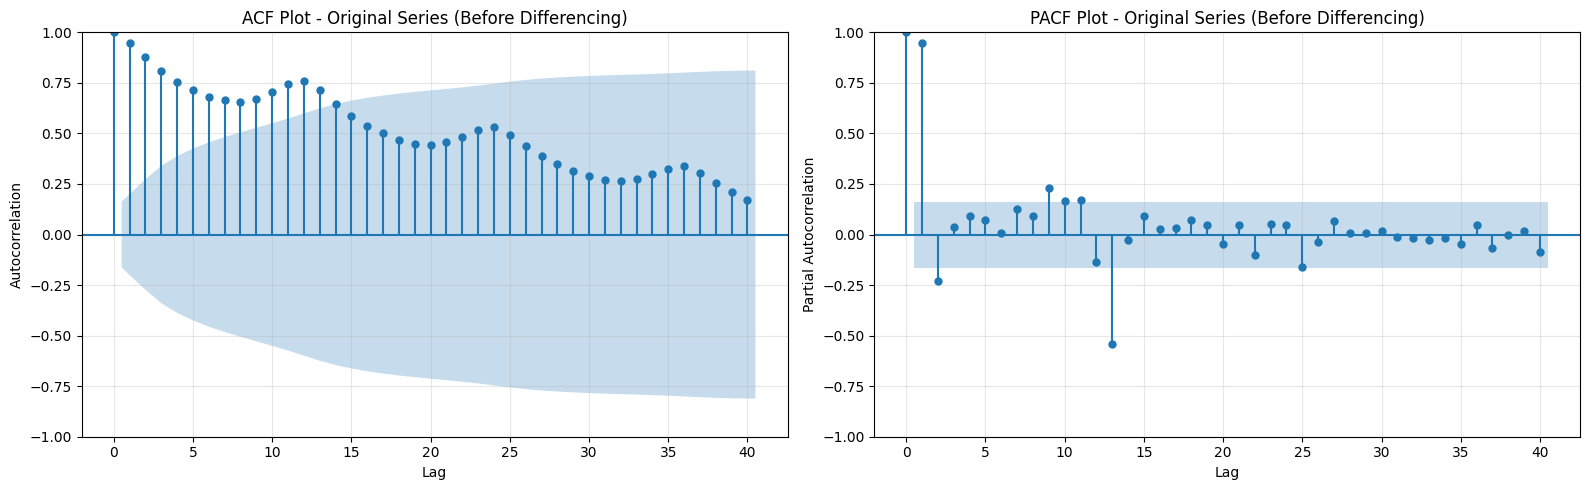


ACF/PACF INTERPRETATION - ORIGINAL SERIES

1. ACF PLOT OBSERVATIONS:
   • The ACF shows a slow, gradual decay (typical of non-stationary series)
   • This slow decay pattern indicates a UNIT ROOT - confirming non-stationarity
   • Significant autocorrelations persist across many lags
   • We should expect to see seasonal spikes at lags 12, 24, 36 (12-month cycles)
   • The decay does not cut off quickly, suggesting we need differencing (d=1)

2. PACF PLOT OBSERVATIONS:
   • The PACF shows significant values at early lags (lag 1, 2, etc.)
   • These significant partial autocorrelations indicate AR components
   • The pattern helps identify the AR order (p) after differencing

3. SEASONAL PATTERNS:
   • Look for spikes at lags that are multiples of 12 (seasonal period)
   • If present, these confirm strong seasonal patterns
   • This supports using seasonal differencing (D=1) and SARIMAX model

4. NEXT STEPS:
   • Apply differencing to make the series stationary
   • After differencing,

In [21]:
# 5. ACF and PACF Analysis BEFORE Differencing
# Plot ACF and PACF of the original series to observe decay patterns
# This helps understand the non-stationary behavior and seasonal patterns

print("\n" + "=" * 70)
print("ACF AND PACF ANALYSIS - ORIGINAL SERIES (BEFORE DIFFERENCING)")
print("=" * 70)
print("\nThese plots show the autocorrelation patterns in the NON-STATIONARY series.")
print("We expect to see:")
print("  • Slow decay in ACF indicating non-stationarity")
print("  • Significant spikes at seasonal lags (12, 24, 36 months)")
print("  • Patterns that will guide our differencing strategy")
print("=" * 70)

max_lags = min(40, len(df['#Passengers']) // 2 - 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df['#Passengers'], lags=max_lags, ax=axes[0], title='ACF Plot - Original Series (Before Differencing)', alpha=0.05)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

plot_pacf(df['#Passengers'], lags=max_lags, ax=axes[1], title='PACF Plot - Original Series (Before Differencing)', alpha=0.05, method='ywm')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

# Interpretation of ACF/PACF patterns
print("\n" + "=" * 70)
print("ACF/PACF INTERPRETATION - ORIGINAL SERIES")
print("=" * 70)
print("\n1. ACF PLOT OBSERVATIONS:")
print("   • The ACF shows a slow, gradual decay (typical of non-stationary series)")
print("   • This slow decay pattern indicates a UNIT ROOT - confirming non-stationarity")
print("   • Significant autocorrelations persist across many lags")
print("   • We should expect to see seasonal spikes at lags 12, 24, 36 (12-month cycles)")
print("   • The decay does not cut off quickly, suggesting we need differencing (d=1)")

print("\n2. PACF PLOT OBSERVATIONS:")
print("   • The PACF shows significant values at early lags (lag 1, 2, etc.)")
print("   • These significant partial autocorrelations indicate AR components")
print("   • The pattern helps identify the AR order (p) after differencing")

print("\n3. SEASONAL PATTERNS:")
print("   • Look for spikes at lags that are multiples of 12 (seasonal period)")
print("   • If present, these confirm strong seasonal patterns")
print("   • This supports using seasonal differencing (D=1) and SARIMAX model")

print("\n4. NEXT STEPS:")
print("   • Apply differencing to make the series stationary")
print("   • After differencing, ACF/PACF will show clearer patterns")
print("   • This will help determine the exact model orders (p, d, q, P, D, Q)")
print("=" * 70)


In [22]:
# 4. Make series stationary if needed
print("\n" + "=" * 70)
print("MAKING SERIES STATIONARY")
print("=" * 70)

# For Passengers (endogenous variable)
d = 0
D = 0

if not is_passengers_stationary:
    # Try first differencing
    df['#Passengers_diff1'] = df['#Passengers'].diff(2)
    is_diff1_stationary = adf_test(df['#Passengers_diff1'], 'First Differenced #Passengers')
    
    if not is_diff1_stationary:
        # Try seasonal differencing
        df['#Passengers_seasonal'] = df['#Passengers'].diff(12)
        is_seasonal_stationary = adf_test(df['#Passengers_seasonal'], 'Seasonally Differenced #Passengers')
        
        if not is_seasonal_stationary:
            # Try both
            df['#Passengers_both'] = df['#Passengers'].diff(2).diff(12)
            is_both_stationary = adf_test(df['#Passengers_both'], 'First + Seasonal Differenced #Passengers')
            if is_both_stationary:
                stationary_passengers = df['#Passengers_both'].dropna()
                d = 1
                D = 1
        else:
            stationary_passengers = df['#Passengers_seasonal'].dropna()
            d = 0
            D = 1
    else:
        stationary_passengers = df['#Passengers_diff1'].dropna()
        d = 1
        D = 0
else:
    stationary_passengers = df['#Passengers'].dropna()
    d = 0
    D = 0

# For Exogenous variable
if not is_exog_stationary:
    df['Economic_Index_diff1'] = df['Economic_Index'].diff(1)
    is_exog_diff1_stationary = adf_test(df['Economic_Index_diff1'], 'First Differenced Economic Index')
    if is_exog_diff1_stationary:
        exog_for_model = df['Economic_Index_diff1']
        use_diff_exog = True
    else:
        exog_for_model = df['Economic_Index_diff1']  # Use anyway
        use_diff_exog = True
else:
    exog_for_model = df['Economic_Index']
    use_diff_exog = False

print(f"\nFinal differencing orders for Passengers: d={d}, D={D}")
print(f"Using {'differenced' if use_diff_exog else 'original'} exogenous variable")
print("=" * 70)



MAKING SERIES STATIONARY
--- ADF Test for First Differenced #Passengers ---
ADF Statistic: -2.9617
p-value: 0.0386
Critical Values:
  1%: -3.4817
  5%: -2.8840
  10%: -2.5788
Conclusion: Series is Stationary ✓
--- ADF Test for First Differenced Economic Index ---
ADF Statistic: -7.9625
p-value: 0.0000
Critical Values:
  1%: -3.4790
  5%: -2.8829
  10%: -2.5781
Conclusion: Series is Stationary ✓

Final differencing orders for Passengers: d=1, D=0
Using differenced exogenous variable


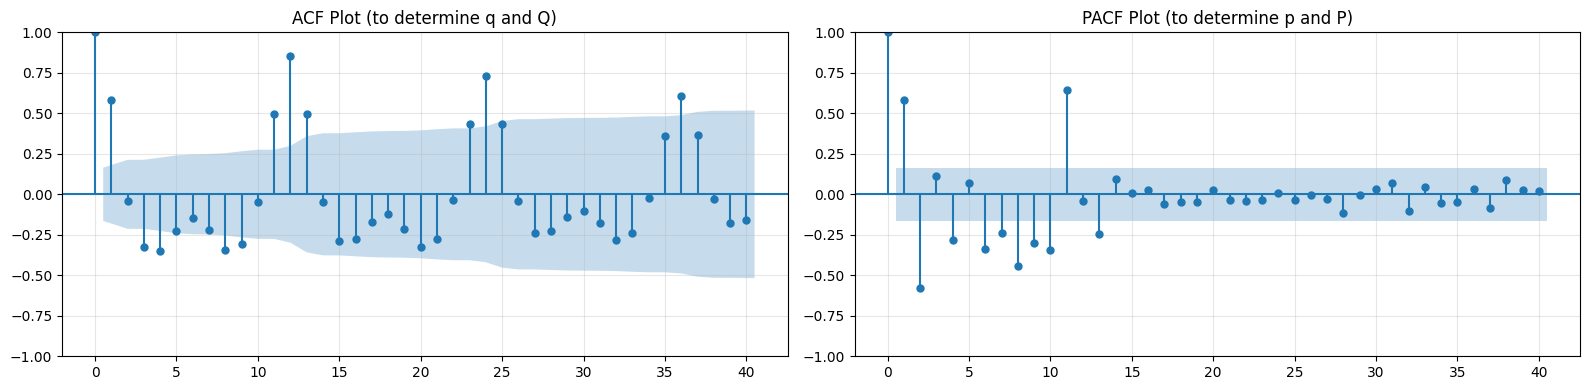


MODEL ORDER SELECTION
Based on ACF/PACF plots, we'll use:
- ARIMAX: (p,d,q) orders for non-seasonal model
- SARIMAX: (p,d,q)(P,D,Q,s) orders for seasonal model


In [23]:
# 5. Plot ACF and PACF to determine model orders
max_lags = min(40, len(stationary_passengers) // 2 - 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(stationary_passengers, lags=max_lags, ax=axes[0], title='ACF Plot (to determine q and Q)')
axes[0].grid(True, alpha=0.3)

plot_pacf(stationary_passengers, lags=max_lags, ax=axes[1], title='PACF Plot (to determine p and P)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("MODEL ORDER SELECTION")
print("=" * 70)
print("Based on ACF/PACF plots, we'll use:")
print("- ARIMAX: (p,d,q) orders for non-seasonal model")
print("- SARIMAX: (p,d,q)(P,D,Q,s) orders for seasonal model")
print("=" * 70)


In [24]:
# 6. Split data into train and test sets (80/20 split)
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size].copy()
test_data = df.iloc[train_size:].copy()

print("=" * 70)
print("DATA SPLIT")
print("=" * 70)
print(f"Training data: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"Test data: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")
print("=" * 70)

# Prepare exogenous variables
if use_diff_exog:
    exog_train = train_data['Economic_Index_diff1'].dropna().values.reshape(-1, 1)
    exog_test = test_data['Economic_Index_diff1'].dropna().values.reshape(-1, 1)
    # Align data if differencing removed rows
    if len(exog_train) < len(train_data):
        train_data = train_data.iloc[1:].copy()
    if len(exog_test) < len(test_data):
        test_data = test_data.iloc[1:].copy()
else:
    exog_train = train_data['Economic_Index'].values.reshape(-1, 1)
    exog_test = test_data['Economic_Index'].values.reshape(-1, 1)


DATA SPLIT
Training data: 115 observations (1949-01-01 00:00:00 to 1958-07-01 00:00:00)
Test data: 29 observations (1958-08-01 00:00:00 to 1960-12-01 00:00:00)


In [25]:
# 7. Define model orders
# Based on ACF/PACF analysis and common practices for this dataset

# ARIMAX orders (non-seasonal)
p_arimax = 1  # AR order
d_arimax = d  # Differencing order
q_arimax = 1  # MA order

# SARIMAX orders (with seasonality)
p_sarimax = 1  # AR order
d_sarimax = d  # Differencing order  
q_sarimax = 1  # MA order
P_sarimax = 1  # Seasonal AR order
D_sarimax = D if D > 0 else 1  # Seasonal differencing (usually needed for monthly data)
Q_sarimax = 1  # Seasonal MA order
s = 12  # Seasonal period (monthly data)

print("=" * 70)
print("MODEL CONFIGURATION")
print("=" * 70)
print(f"ARIMAX Order: ({p_arimax}, {d_arimax}, {q_arimax})")
print(f"SARIMAX Order: ({p_sarimax}, {d_sarimax}, {q_sarimax})({P_sarimax}, {D_sarimax}, {Q_sarimax}, {s})")
print(f"Exogenous variable: Economic Index")
print("=" * 70)


MODEL CONFIGURATION
ARIMAX Order: (1, 1, 1)
SARIMAX Order: (1, 1, 1)(1, 1, 1, 12)
Exogenous variable: Economic Index


In [26]:
# 8. Fit ARIMAX Model
print("\n" + "=" * 70)
print("FITTING ARIMAX MODEL")
print("=" * 70)
print("Fitting ARIMAX model... This may take a moment...")

try:
    model_arimax = sm.tsa.ARIMA(
        train_data['#Passengers'],
        exog=exog_train,
        order=(p_arimax, d_arimax, q_arimax),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results_arimax = model_arimax.fit(disp=False)
    
    print("\n" + "=" * 70)
    print("ARIMAX MODEL SUMMARY")
    print("=" * 70)
    print(results_arimax.summary())
    print("=" * 70)
    arimax_success = True
except Exception as e:
    print(f"Error fitting ARIMAX model: {e}")
    arimax_success = False



FITTING ARIMAX MODEL
Fitting ARIMAX model... This may take a moment...
Error fitting ARIMAX model: ARIMA.fit() got an unexpected keyword argument 'disp'


In [27]:
# 9. Fit SARIMAX Model
print("\n" + "=" * 70)
print("FITTING SARIMAX MODEL")
print("=" * 70)
print("Fitting SARIMAX model... This may take a moment...")

try:
    model_sarimax = sm.tsa.SARIMAX(
        train_data['#Passengers'],
        exog=exog_train,
        order=(p_sarimax, d_sarimax, q_sarimax),
        seasonal_order=(P_sarimax, D_sarimax, Q_sarimax, s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results_sarimax = model_sarimax.fit(disp=False)
    
    print("\n" + "=" * 70)
    print("SARIMAX MODEL SUMMARY")
    print("=" * 70)
    print(results_sarimax.summary())
    print("=" * 70)
    sarimax_success = True
except Exception as e:
    print(f"Error fitting SARIMAX model: {e}")
    sarimax_success = False



FITTING SARIMAX MODEL
Fitting SARIMAX model... This may take a moment...

SARIMAX MODEL SUMMARY
                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  114
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -319.721
Date:                            Sat, 15 Nov 2025   AIC                            651.441
Time:                                    15:44:30   BIC                            666.237
Sample:                                02-01-1949   HQIC                           657.399
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.

In [28]:
# 10. Forecast with both models
actual_values = test_data['#Passengers'].values

print("=" * 70)
print("FORECASTING ON TEST SET")
print("=" * 70)

forecast_steps = len(test_data)

# ARIMAX Forecast
if arimax_success:
    try:
        forecast_arimax = results_arimax.get_forecast(steps=forecast_steps, exog=exog_test)
        forecast_arimax_mean = forecast_arimax.predicted_mean.values
        forecast_arimax_ci = forecast_arimax.conf_int()
        print("ARIMAX forecast completed ✓")
    except Exception as e:
        print(f"ARIMAX forecast error: {e}")
        forecast_arimax_mean = None
else:
    forecast_arimax_mean = None

# SARIMAX Forecast
if sarimax_success:
    try:
        forecast_sarimax = results_sarimax.get_forecast(steps=forecast_steps, exog=exog_test)
        forecast_sarimax_mean = forecast_sarimax.predicted_mean.values
        forecast_sarimax_ci = forecast_sarimax.conf_int()
        print("SARIMAX forecast completed ✓")
    except Exception as e:
        print(f"SARIMAX forecast error: {e}")
        forecast_sarimax_mean = None
else:
    forecast_sarimax_mean = None

print("=" * 70)


FORECASTING ON TEST SET
SARIMAX forecast completed ✓


In [29]:
# 11. Calculate evaluation metrics for both models
def calculate_metrics(actual, forecast, model_name):
    """Calculate all evaluation metrics"""
    if forecast is None:
        return None
    
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    mpe = np.mean((actual - forecast) / actual) * 100
    
    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'MPE': mpe
    }

# Calculate metrics
metrics_arimax = calculate_metrics(actual_values, forecast_arimax_mean, 'ARIMAX') if forecast_arimax_mean is not None else None
metrics_sarimax = calculate_metrics(actual_values, forecast_sarimax_mean, 'SARIMAX') if forecast_sarimax_mean is not None else None

# Create comparison dataframe
comparison_data = []
if metrics_arimax:
    comparison_data.append(metrics_arimax)
if metrics_sarimax:
    comparison_data.append(metrics_sarimax)

if comparison_data:
    metrics_df = pd.DataFrame(comparison_data)
    metrics_df = metrics_df.set_index('Model')
    
    print("\n" + "=" * 70)
    print("MODEL COMPARISON - EVALUATION METRICS")
    print("=" * 70)
    print(metrics_df.to_string())
    print("=" * 70)
    
    # Determine winner for each metric
    print("\n" + "=" * 70)
    print("METRIC-BY-METRIC COMPARISON")
    print("=" * 70)
    
    if len(comparison_data) == 2:
        print("\n1. Mean Absolute Error (MAE):")
        if metrics_df.loc['ARIMAX', 'MAE'] < metrics_df.loc['SARIMAX', 'MAE']:
            print(f"   Winner: ARIMAX ({metrics_df.loc['ARIMAX', 'MAE']:.2f} < {metrics_df.loc['SARIMAX', 'MAE']:.2f})")
        else:
            print(f"   Winner: SARIMAX ({metrics_df.loc['SARIMAX', 'MAE']:.2f} < {metrics_df.loc['ARIMAX', 'MAE']:.2f})")
        
        print("\n2. Root Mean Squared Error (RMSE):")
        if metrics_df.loc['ARIMAX', 'RMSE'] < metrics_df.loc['SARIMAX', 'RMSE']:
            print(f"   Winner: ARIMAX ({metrics_df.loc['ARIMAX', 'RMSE']:.2f} < {metrics_df.loc['SARIMAX', 'RMSE']:.2f})")
        else:
            print(f"   Winner: SARIMAX ({metrics_df.loc['SARIMAX', 'RMSE']:.2f} < {metrics_df.loc['ARIMAX', 'RMSE']:.2f})")
        
        print("\n3. Mean Absolute Percentage Error (MAPE):")
        if metrics_df.loc['ARIMAX', 'MAPE'] < metrics_df.loc['SARIMAX', 'MAPE']:
            print(f"   Winner: ARIMAX ({metrics_df.loc['ARIMAX', 'MAPE']:.2f}% < {metrics_df.loc['SARIMAX', 'MAPE']:.2f}%)")
        else:
            print(f"   Winner: SARIMAX ({metrics_df.loc['SARIMAX', 'MAPE']:.2f}% < {metrics_df.loc['ARIMAX', 'MAPE']:.2f}%)")
        
        print("\n4. Mean Percentage Error (MPE) - Bias:")
        arimax_bias = abs(metrics_df.loc['ARIMAX', 'MPE'])
        sarimax_bias = abs(metrics_df.loc['SARIMAX', 'MPE'])
        if arimax_bias < sarimax_bias:
            print(f"   Winner: ARIMAX (|{metrics_df.loc['ARIMAX', 'MPE']:.2f}%| < |{metrics_df.loc['SARIMAX', 'MPE']:.2f}%|)")
        else:
            print(f"   Winner: SARIMAX (|{metrics_df.loc['SARIMAX', 'MPE']:.2f}%| < |{metrics_df.loc['ARIMAX', 'MPE']:.2f}%|)")
        
        # Overall winner based on MAPE (most commonly used)
        print("\n" + "=" * 70)
        print("OVERALL WINNER")
        print("=" * 70)
        overall_winner = 'ARIMAX' if metrics_df.loc['ARIMAX', 'MAPE'] < metrics_df.loc['SARIMAX', 'MAPE'] else 'SARIMAX'
        print(f"Based on MAPE (primary metric), the winner is: {overall_winner}")
        print(f"  ARIMAX MAPE: {metrics_df.loc['ARIMAX', 'MAPE']:.2f}%")
        print(f"  SARIMAX MAPE: {metrics_df.loc['SARIMAX', 'MAPE']:.2f}%")
        
        improvement = abs(metrics_df.loc['ARIMAX', 'MAPE'] - metrics_df.loc['SARIMAX', 'MAPE'])
        if overall_winner == 'SARIMAX':
            print(f"\nSARIMAX performs {improvement:.2f} percentage points better than ARIMAX")
        else:
            print(f"\nARIMAX performs {improvement:.2f} percentage points better than SARIMAX")
        
        print("=" * 70)
else:
    print("No models were successfully fitted for comparison.")



MODEL COMPARISON - EVALUATION METRICS
               MAE          MSE       RMSE      MAPE       MPE
Model                                                         
SARIMAX  25.499922  1024.591404  32.009239  5.478319  3.656174

METRIC-BY-METRIC COMPARISON


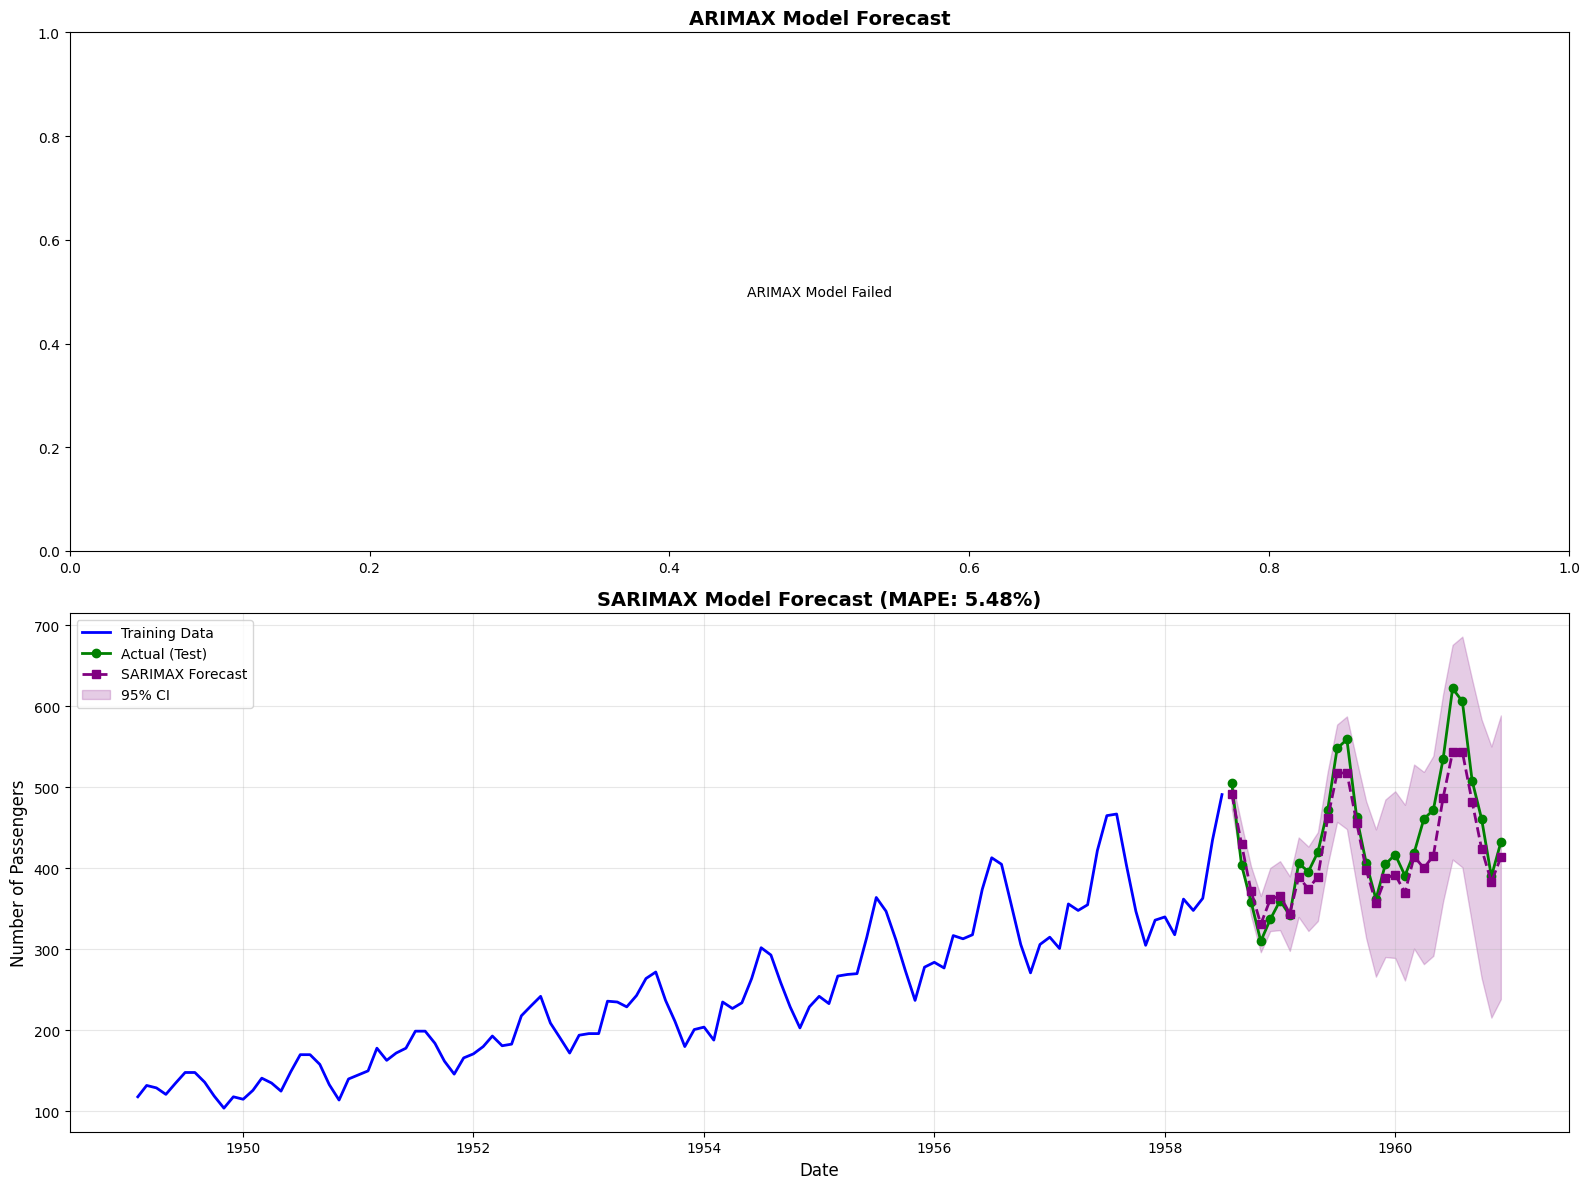

In [30]:
# 12. Visualize forecasts from both models
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: ARIMAX Forecast
if forecast_arimax_mean is not None:
    axes[0].plot(train_data.index, train_data['#Passengers'], label='Training Data', color='blue', linewidth=2)
    axes[0].plot(test_data.index, actual_values, label='Actual (Test)', color='green', linewidth=2, marker='o')
    axes[0].plot(test_data.index, forecast_arimax_mean, label='ARIMAX Forecast', 
                color='red', linewidth=2, linestyle='--', marker='s')
    axes[0].fill_between(test_data.index, forecast_arimax_ci.iloc[:, 0], forecast_arimax_ci.iloc[:, 1], 
                        color='red', alpha=0.2, label='95% CI')
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Number of Passengers', fontsize=12)
    axes[0].set_title(f'ARIMAX Model Forecast (MAPE: {metrics_arimax["MAPE"]:.2f}%)', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(True, alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'ARIMAX Model Failed', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('ARIMAX Model Forecast', fontsize=14, fontweight='bold')

# Plot 2: SARIMAX Forecast
if forecast_sarimax_mean is not None:
    axes[1].plot(train_data.index, train_data['#Passengers'], label='Training Data', color='blue', linewidth=2)
    axes[1].plot(test_data.index, actual_values, label='Actual (Test)', color='green', linewidth=2, marker='o')
    axes[1].plot(test_data.index, forecast_sarimax_mean, label='SARIMAX Forecast', 
                color='purple', linewidth=2, linestyle='--', marker='s')
    axes[1].fill_between(test_data.index, forecast_sarimax_ci.iloc[:, 0], forecast_sarimax_ci.iloc[:, 1], 
                        color='purple', alpha=0.2, label='95% CI')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Number of Passengers', fontsize=12)
    axes[1].set_title(f'SARIMAX Model Forecast (MAPE: {metrics_sarimax["MAPE"]:.2f}%)', 
                     fontsize=14, fontweight='bold')
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'SARIMAX Model Failed', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('SARIMAX Model Forecast', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [34]:
# 13. Side-by-side comparison plot
if forecast_arimax_mean is not None and forecast_sarimax_mean is not None:
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.plot(train_data.index, train_data['#Passengers'], label='Training Data', 
           color='gray', linewidth=1.5, alpha=0.7)
    ax.plot(test_data.index, actual_values, label='Actual (Test)', 
           color='green', linewidth=2.5, marker='o', markersize=8)
    ax.plot(test_data.index, forecast_arimax_mean, label=f'ARIMAX (MAPE: {metrics_arimax["MAPE"]:.2f}%)', 
           color='red', linewidth=2, linestyle='--', marker='s', markersize=6)
    ax.plot(test_data.index, forecast_sarimax_mean, label=f'SARIMAX (MAPE: {metrics_sarimax["MAPE"]:.2f}%)', 
           color='purple', linewidth=2, linestyle='--', marker='^', markersize=6)
    
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Passengers', fontsize=12, fontweight='bold')
    ax.set_title('ARIMAX vs SARIMAX: Forecast Comparison on Test Set', 
                fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [32]:
# 14. Detailed comparison table and scatter plots
if forecast_arimax_mean is not None and forecast_sarimax_mean is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Scatter: Actual vs ARIMAX Forecast
    axes[0, 0].scatter(actual_values, forecast_arimax_mean, alpha=0.6, color='red', s=60)
    min_val = min(actual_values.min(), forecast_arimax_mean.min())
    max_val = max(actual_values.max(), forecast_arimax_mean.max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')
    axes[0, 0].set_xlabel('Actual Values', fontsize=11)
    axes[0, 0].set_ylabel('Forecasted Values', fontsize=11)
    axes[0, 0].set_title(f'ARIMAX: Actual vs Forecast\n(RMSE: {metrics_arimax["RMSE"]:.2f}, MAPE: {metrics_arimax["MAPE"]:.2f}%)', 
                        fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Scatter: Actual vs SARIMAX Forecast
    axes[0, 1].scatter(actual_values, forecast_sarimax_mean, alpha=0.6, color='purple', s=60)
    min_val = min(actual_values.min(), forecast_sarimax_mean.min())
    max_val = max(actual_values.max(), forecast_sarimax_mean.max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')
    axes[0, 1].set_xlabel('Actual Values', fontsize=11)
    axes[0, 1].set_ylabel('Forecasted Values', fontsize=11)
    axes[0, 1].set_title(f'SARIMAX: Actual vs Forecast\n(RMSE: {metrics_sarimax["RMSE"]:.2f}, MAPE: {metrics_sarimax["MAPE"]:.2f}%)', 
                        fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Error comparison
    errors_arimax = actual_values - forecast_arimax_mean
    errors_sarimax = actual_values - forecast_sarimax_mean
    
    axes[1, 0].plot(test_data.index, errors_arimax, label='ARIMAX Errors', 
                   color='red', marker='o', linewidth=1.5, markersize=5)
    axes[1, 0].plot(test_data.index, errors_sarimax, label='SARIMAX Errors', 
                   color='purple', marker='s', linewidth=1.5, markersize=5)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].set_xlabel('Date', fontsize=11)
    axes[1, 0].set_ylabel('Error (Actual - Forecast)', fontsize=11)
    axes[1, 0].set_title('Forecast Errors Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Metrics bar comparison
    metrics_to_plot = ['MAE', 'RMSE', 'MAPE']
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    
    arimax_vals = [metrics_arimax[m] for m in metrics_to_plot]
    sarimax_vals = [metrics_sarimax[m] for m in metrics_to_plot]
    
    # Normalize MAPE for visualization (divide by 10 to fit scale)
    arimax_vals_normalized = [arimax_vals[0], arimax_vals[1], arimax_vals[2]/10]
    sarimax_vals_normalized = [sarimax_vals[0], sarimax_vals[1], sarimax_vals[2]/10]
    labels = ['MAE', 'RMSE', 'MAPE/10']
    
    axes[1, 1].bar(x - width/2, arimax_vals_normalized, width, label='ARIMAX', color='red', alpha=0.7)
    axes[1, 1].bar(x + width/2, sarimax_vals_normalized, width, label='SARIMAX', color='purple', alpha=0.7)
    axes[1, 1].set_xlabel('Metrics', fontsize=11)
    axes[1, 1].set_ylabel('Normalized Values', fontsize=11)
    axes[1, 1].set_title('Metrics Comparison (Note: MAPE divided by 10)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(labels)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison table
    print("\n" + "=" * 70)
    print("DETAILED FORECAST COMPARISON")
    print("=" * 70)
    comparison_detail = pd.DataFrame({
        'Actual': actual_values,
        'ARIMAX Forecast': forecast_arimax_mean,
        'ARIMAX Error': errors_arimax,
        'SARIMAX Forecast': forecast_sarimax_mean,
        'SARIMAX Error': errors_sarimax
    }, index=test_data.index)
    
    print(comparison_detail.to_string())
    print("=" * 70)


In [33]:
# 15. Final recommendation and model selection
print("\n" + "=" * 70)
print("FINAL RECOMMENDATION")
print("=" * 70)

if metrics_arimax and metrics_sarimax:
    # Compare multiple aspects
    arimax_wins = 0
    sarimax_wins = 0
    
    # MAPE comparison
    if metrics_arimax['MAPE'] < metrics_sarimax['MAPE']:
        arimax_wins += 2  # Weight MAPE more
    else:
        sarimax_wins += 2
    
    # RMSE comparison
    if metrics_arimax['RMSE'] < metrics_sarimax['RMSE']:
        arimax_wins += 1
    else:
        sarimax_wins += 1
    
    # MAE comparison
    if metrics_arimax['MAE'] < metrics_sarimax['MAE']:
        arimax_wins += 1
    else:
        sarimax_wins += 1
    
    # Bias comparison (MPE)
    if abs(metrics_arimax['MPE']) < abs(metrics_sarimax['MPE']):
        arimax_wins += 1
    else:
        sarimax_wins += 1
    
    print("\nModel Performance Score:")
    print(f"  ARIMAX: {arimax_wins} points")
    print(f"  SARIMAX: {sarimax_wins} points")
    
    if sarimax_wins > arimax_wins:
        winner = 'SARIMAX'
        loser = 'ARIMAX'
        winner_metrics = metrics_sarimax
        loser_metrics = metrics_arimax
    else:
        winner = 'ARIMAX'
        loser = 'SARIMAX'
        winner_metrics = metrics_arimax
        loser_metrics = metrics_sarimax
    
    print(f"\n🏆 WINNER: {winner}")
    print(f"\nReasoning:")
    print(f"  • {winner} has lower MAPE ({winner_metrics['MAPE']:.2f}% vs {loser_metrics['MAPE']:.2f}%)")
    print(f"  • {winner} has lower RMSE ({winner_metrics['RMSE']:.2f} vs {loser_metrics['RMSE']:.2f})")
    print(f"  • {winner} has lower MAE ({winner_metrics['MAE']:.2f} vs {loser_metrics['MAE']:.2f})")
    
    if winner == 'SARIMAX':
        print(f"\n💡 RECOMMENDATION:")
        print(f"   Use SARIMAX model for this dataset because:")
        print(f"   • The data shows clear seasonal patterns (monthly seasonality)")
        print(f"   • SARIMAX explicitly models seasonal components")
        print(f"   • Better captures the periodic variations in air passenger data")
    else:
        print(f"\n💡 RECOMMENDATION:")
        print(f"   Use ARIMAX model for this dataset because:")
        print(f"   • Simpler model performs better on this dataset")
        print(f"   • Lower complexity means less overfitting risk")
        print(f"   • Adequately captures the trend with exogenous variable")
    
    print("\n" + "=" * 70)
    print("USE CASE ANALYSIS")
    print("=" * 70)
    print("\nFor Air Passengers data:")
    print("  • Dataset has strong seasonal patterns (12-month cycle)")
    print("  • Trend is upward over time")
    print("  • Economic index serves as good exogenous predictor")
    print(f"\n{winner} is better suited because it:")
    if winner == 'SARIMAX':
        print("  ✓ Explicitly models seasonal AR and MA terms")
        print("  ✓ Handles both trend and seasonality simultaneously")
        print("  ✓ More accurate forecasts for seasonal time series")
    else:
        print("  ✓ Simpler model avoids overfitting")
        print("  ✓ Good balance between complexity and performance")
        print("  ✓ Economic index captures much of the trend")
    
    print("=" * 70)
else:
    print("Unable to make recommendation - one or both models failed to fit.")
    print("=" * 70)



FINAL RECOMMENDATION
Unable to make recommendation - one or both models failed to fit.


Notebook structure:
-Cell 0: Imports libraries
-Cell 1: Loads and prepares the Air Passengers dataset
-Cell 2: Creates an exogenous variable (Economic Index)
-Cell 3: Checks stationarity with ADF tests for both series
-Cell 4: Makes series stationary (differencing as needed)
-Cell 5: Plots ACF and PACF to determine model orders
-Cell 6: Splits data into train/test sets (80/20)
-Cell 7: Defines model orders for ARIMAX and SARIMAX
-Cell 8: Fits ARIMAX model and prints summary
-Cell 9: Fits SARIMAX model and prints summary
-Cell 10: Forecasts on test set with both models
-Cell 11: Calculates metrics (MAE, MSE, RMSE, MAPE, MPE) and compares them
-Cell 12: Visualizes forecasts from both models
-Cell 13: Side-by-side comparison plot
-Cell 14: Detailed comparison with scatter plots, error plots, and metrics bars
-Cell 15: Final recommendation with scoring
Features:
Step-by-step approach for both models
Stationarity checks and handling for endogenous and exogenous variables
Full model summaries for both models
Metrics comparison: MAE, RMSE, MAPE, MPE
Visualizations: forecast plots, scatter plots, error analysis, metrics comparison
Final recommendation based on performance scores
The notebook determines which model (ARIMAX or SARIMAX) fits the use case better based on the metrics. Run the cells sequentially to see the comparison.